## sys.pathの設定

In [1]:
import sys
sys.path.append('..')

# double_comvolution_network

In [2]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

class DoubleConvNet:
    # conv - relu - conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1={'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
                 conv_param_2={'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10, weight_init_std=0.01):
        conv_output_size_1 = (input_dim[1] - conv_param_1['filter_size'] + 2 * conv_param_1['pad']) / conv_param_1['stride'] + 1
        conv_output_size_2 = (conv_output_size_1 - conv_param_2['filter_size'] + 2 * conv_param_2['pad']) / conv_param_2['stride'] + 1        
        pool_output_size = int(conv_param_2['filter_num'] * (conv_output_size_2 / 2) * (conv_output_size_2 / 2))        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size'])
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = weight_init_std * np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size'])
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])
        self.params['W3'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Conv2'] = layers.Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W4'], self.params['b4'])
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db        
        grad['W3'], grad['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W4'], grad['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.2232
                : 10. 正答率(テスト) = 0.237
Generation: 20. 正答率(トレーニング) = 0.5216
                : 20. 正答率(テスト) = 0.502
Generation: 30. 正答率(トレーニング) = 0.7008
                : 30. 正答率(テスト) = 0.674
Generation: 40. 正答率(トレーニング) = 0.7952
                : 40. 正答率(テスト) = 0.759
Generation: 50. 正答率(トレーニング) = 0.8262
                : 50. 正答率(テスト) = 0.786
Generation: 60. 正答率(トレーニング) = 0.8444
                : 60. 正答率(テスト) = 0.822
Generation: 70. 正答率(トレーニング) = 0.8534
                : 70. 正答率(テスト) = 0.831
Generation: 80. 正答率(トレーニング) = 0.8416
                : 80. 正答率(テスト) = 0.799
Generation: 90. 正答率(トレーニング) = 0.8744
                : 90. 正答率(テスト) = 0.852
Generation: 100. 正答率(トレーニング) = 0.8744
                : 100. 正答率(テスト) = 0.857


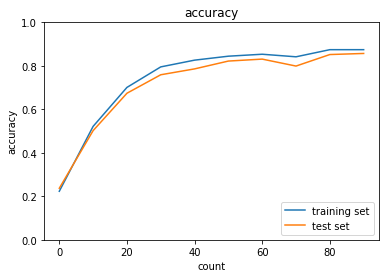

In [3]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")
# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]


network = DoubleConvNet(input_dim=(1,28,28), 
                          conv_param_1={'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
                          conv_param_2={'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1},
                          hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

# 時間がかかるため100に設定
iters_num = 100
# iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()